<a href="https://colab.research.google.com/github/IgorekFromRU/HyperParametrOptimization/blob/master/ML_7_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B8%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D1%82%D0%B2%D0%B5%D1%82%D0%B0_(HW_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-7. Прогнозирование биологического ответа (HW-3)

![Biomolecules](https://media.geeksforgeeks.org/wp-content/uploads/20220719115043/C581.png)

## Задача

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу
(столбцы D1-D1776).

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
from time import time
import numpy as np
import pandas as pd #для анализа и предобработки данных

from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier #деревья решений
from sklearn.ensemble import RandomForestClassifier #ансамбли
from sklearn.metrics import  f1_score #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOMSTATE = 42
MAX_ITER = 50
name_lr = 'LogisticRegression'
name_rf = 'RandomForestClassifier'
ROUND_OUT = 4
F1 = 'f1'

clf_log_reg = LogisticRegression(random_state=RANDOMSTATE)
clf_log_reg.name = 'Logistic Regression'

clf_rand_forest = RandomForestClassifier(random_state=RANDOMSTATE)
clf_rand_forest.name = 'RandomForestClassifier'

---

## 1. Знакомство с данными и их исследование

Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

In [3]:

#ЕСЛИ РАБОТАЕМ В IDE
#data = pd.read_csv('data\_train_sem09__1_.zip')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
data = pd.read_csv('./drive/MyDrive/DS/data/_train_sem09__1_.zip')
data.head(2)

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


In [4]:
print('Размер таблицы: ', data.shape)
print('Наличие пропусков: ', data.isnull().sum().sum())

Размер таблицы:  (3751, 1777)
Наличие пропусков:  0


Смотрим на сбалансированность классов:

In [5]:
#sns.countplot(data=data, x='Activity')
data['Activity'].value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Создаем матрицу наблюдений $X$ и вектор ответов $y$

Разделим выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [6]:
X, y = data.drop(['Activity'], axis=1), data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = RANDOMSTATE, test_size = 0.2)

In [18]:
# создадим таблицу для обобщения итогов
score_table = pd.DataFrame(columns=['name_model','optimization', 'test_f1', 'best_params', 'time'])

# Utility function to report
def report(name_model, hpo, test_score, total_seconds, best_params=None):
    total_seconds_ = f'{int(total_seconds // 60)} минут {int(total_seconds % 60)} секунд'
    score_table.loc[ len(score_table.index )] = [name_model, hpo, test_score.round(ROUND_OUT), best_params, total_seconds_]
    print(f'Классификатор: {name_model}. Оптимизация гиперпараметров: {hpo}.')
    print(f'Метрика {F1}_score на тестовом наборе: {test_score:.{ROUND_OUT}f}')
    print('Наилучшие значения гиперпараметров: ', best_params)
    print('Время вычисления: ', total_seconds_)

def f1_score_evaluation(estimator, params):
  estimator.set_params(**params).fit(X_train, y_train)
  return f1_score(y_test, estimator.predict(X_test))


---
## 2. Базовая оптимизация

### **LogisticRegression**

In [21]:
default_params = {'penalty':'l2', 'C':1.0, 'solver':'lbfgs'}

hpo_name='default'
estimator = clf_log_reg.set_params(**default_params)
tic = time()
estimator.fit(X_train,y_train)
tic_end = time()-tic

test_f1 = f1_score(y_test, estimator.predict(X_test))
report(estimator.name, hpo_name, test_f1, tic_end, best_params=default_params)

Классификатор: Logistic Regression. Оптимизация гиперпараметров: default.
Метрика f1_score на тестовом наборе: 0.7798
Наилучшие значения гиперпараметров:  {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs'}
Время вычисления:  0 минут 0 секунд


### **RandomForestClassifier**

In [23]:
default_params={'n_estimators':100, 'max_depth':None, 'min_samples_leaf':1}

hpo_name='default'
estimator = clf_rand_forest.set_params(**default_params)
tic = time()
estimator.fit(X_train,y_train)
tic_end = time()-tic

test_f1 = f1_score(y_test, estimator.predict(X_test))
report(estimator.name, hpo_name, test_f1, tic_end, best_params=default_params)

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: default.
Метрика f1_score на тестовом наборе: 0.8048
Наилучшие значения гиперпараметров:  {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
Время вычисления:  0 минут 2 секунд


## 3. GridSearchCV


###  **LogisticRegression**
#### Алгоритм оптимизации для LogisticRegression зависит от выбранного типа штрафа:

- 'newton-cg' - ['l2', 'none']
- 'lbfgs' - ['l2', 'none']
- 'liblinear' - ['l1', 'l2']
- 'sag' - ['l2', 'none']
- 'saga' - [elasticnet', 'l1', 'l2', 'none']

In [24]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регуляризации

              # {'penalty': ['l1', 'l2'] ,
              # 'solver': ['liblinear', 'saga'],
              #  'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

hpo_name = 'GridSearchCV'
estimator = clf_log_reg
hpo_search = GridSearchCV(
    estimator=estimator
    , param_grid=param_grid
    # For int/None inputs, if the estimator is a classifier and y is
    # either binary or multiclass, StratifiedKFold is used. In all
    # other cases, KFold is used.
    , cv=5
    , scoring='f1'
    , n_jobs = -1
    )

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
# Оба варианта вычисляют F1-меру на тестовом наборе данных
# с использованием модели, обученной с лучшими гиперпараметрами.
# Разница заключается в том, как это делается - через метод .score
# или через явное предсказание metrics.f1_score
#print(f"f1 на тестовом наборе: {hpo_search.score(X_test, y_test):.4f}")
#test_f1 = f1_score(y_test, hpo_search.predict(X_test))
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: Logistic Regression. Оптимизация гиперпараметров: GridSearchCV.
Метрика f1_score на тестовом наборе: 0.7824
Наилучшие значения гиперпараметров:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Время вычисления:  3 минут 53 секунд


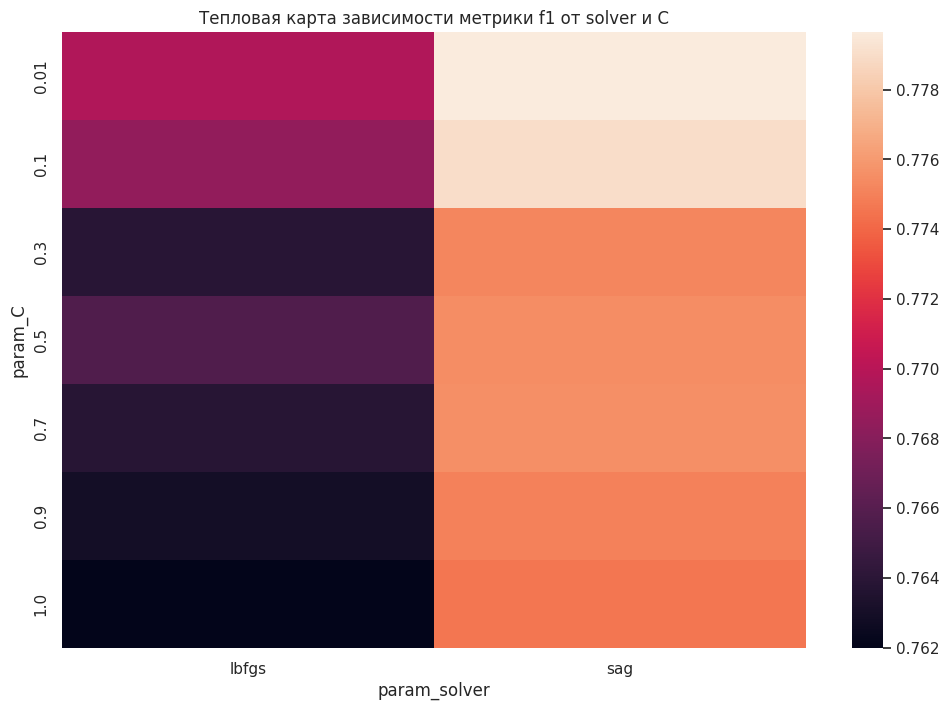

In [25]:
# отрисуем, как менялась метрика f1 при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(hpo_search.cv_results_)
                        , values='mean_test_score', index='param_C'
                        # , columns='param_penalty'
                        , columns='param_solver'
                      )
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики f1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

### **RandomForestClassifier**

In [26]:
param_grid = {'n_estimators': list(range(80, 200, 30))
              , 'min_samples_leaf': list(np.linspace(1, 10, 2, dtype=int)) #[5]
              , 'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }

hpo_name = 'GridSearchCV'
estimator = clf_rand_forest
hpo_search = GridSearchCV(
    estimator=estimator
    , param_grid=param_grid
    , cv=5
    , scoring='f1'
    , n_jobs = -1
    )

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: GridSearchCV.
Метрика f1_score на тестовом наборе: 0.8092
Наилучшие значения гиперпараметров:  {'max_depth': 17, 'min_samples_leaf': 1, 'n_estimators': 170}
Время вычисления:  3 минут 28 секунд


---
## HalvingGridSearchCV

### LogisticRegression

In [27]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = [
              { 'penalty': ['l2', 'none']
               , 'solver': ['lbfgs', 'sag']
               , 'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
              },
]

hpo_name = 'HalvingGridSearchCV'
estimator = clf_log_reg
hpo_search =HalvingGridSearchCV(
    estimator=estimator
    , param_grid=param_grid
    , cv=5
    , scoring='f1'
    , n_jobs = -1
    , factor=2
    )

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: Logistic Regression. Оптимизация гиперпараметров: HalvingGridSearchCV.
Метрика f1_score на тестовом наборе: 0.7857
Наилучшие значения гиперпараметров:  {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Время вычисления:  1 минут 21 секунд


### RandomForestClassifier

In [29]:
param_grid = {'n_estimators': list(range(80, 200, 30))
              , 'min_samples_leaf': list(np.linspace(1, 10, 2, dtype=int)) #[5]
              , 'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }

hpo_name = 'HalvingGridSearchCV'
estimator = clf_rand_forest
hpo_search = HalvingGridSearchCV(estimator=estimator,
                                 param_grid=param_grid,
                                 cv=5,
                                 scoring='f1',
                                 n_jobs = -1,
                                 factor=2
)

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: HalvingGridSearchCV.
Метрика f1_score на тестовом наборе: 0.8132
Наилучшие значения гиперпараметров:  {'max_depth': 32, 'min_samples_leaf': 1, 'n_estimators': 140}
Время вычисления:  1 минут 47 секунд


---
## 4. RandomizedSearchCV

### **LogisticRegression**

In [30]:
param_distributions = {'penalty': ['l2', 'none'] ,
                        'solver': ['lbfgs', 'sag'],
                        'C': list(np.linspace(0.01, 1, 10, dtype=float))
                      }

hpo_name = 'RandomizedSearchCV'
estimator = clf_log_reg
hpo_search = RandomizedSearchCV(
    estimator=estimator
    , param_distributions=param_distributions
    , cv=5
    , scoring='f1'
    , n_iter = MAX_ITER #10
    , n_jobs = -1
)

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: Logistic Regression. Оптимизация гиперпараметров: RandomizedSearchCV.
Метрика f1_score на тестовом наборе: 0.7824
Наилучшие значения гиперпараметров:  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
Время вычисления:  5 минут 34 секунд


### **RandomForestClassifier**

In [32]:
param_distributions = {'n_estimators': list(range(80, 200, 1))
                       , 'min_samples_leaf': list(np.linspace(2, 10, 2, dtype=int)) #[5]
                       , 'max_depth': list(np.linspace(10, 40, 1, dtype=int))
                      }

hpo_name = 'RandomizedSearchCV'
estimator = clf_rand_forest
hpo_search = RandomizedSearchCV(
    estimator=estimator
    , param_distributions=param_distributions
    , cv=5
    , scoring='f1'
    , n_iter = MAX_ITER #10
    , n_jobs = -1
)

tic=time()
hpo_search.fit(X_train, y_train)
tic_end = time()-tic

best_params = hpo_search.best_params_
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: RandomizedSearchCV.
Метрика f1_score на тестовом наборе: 0.7908
Наилучшие значения гиперпараметров:  {'n_estimators': 159, 'min_samples_leaf': 2, 'max_depth': 10}
Время вычисления:  3 минут 55 секунд


---
## 5. Hyperopt

In [33]:
#делаем импорт и выведем версию библиотеки

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : ", hyperopt.__version__)

Версия Hyperopt :  0.2.7


### **LogisticRegression**

In [35]:
def hyperopt_lr(params):
  estimator = clf_log_reg
  estimator.set_params(**params)

  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs = -1).mean()

  # Возвращаем минус среднюю F1-меру, так как Hyperopt максимизирует функцию, а мы хотим минимизировать метрику
  return {'loss': -mean_f1, 'status': STATUS_OK}
  # score = metrics.f1_score(y_train, estimator.predict(X_train))
  # return -1.0 * score

#----------------------------------------------#
trials = Trials() # используется для логирования результатов

space = {
          'penalty': hp.choice('penalty', ['l2', 'none']),
          'solver': hp.choice('solver', ['lbfgs', 'sag']),
          'C': hp.uniform('C', 0.01, 1.0)
}
hpo_name = 'HyperOpt (CV)'

# начинаем подбор гиперпараметров
tic = time()
best = fmin(fn=hyperopt_lr, space=space, algo=tpe.suggest, max_evals=MAX_ITER, trials=trials,
                rstate=np.random.default_rng(RANDOMSTATE))
tic_end = time()-tic

best_params = hyperopt.space_eval(space, best)
estimator = clf_log_reg
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

100%|██████████| 50/50 [05:02<00:00,  6.06s/trial, best loss: -0.7938189329497317]
Классификатор: Logistic Regression. Оптимизация гиперпараметров: HyperOpt (CV).
Метрика f1_score на тестовом наборе: 0.7787
Наилучшие значения гиперпараметров:  {'C': 0.017331323696411022, 'penalty': 'l2', 'solver': 'lbfgs'}
Время вычисления:  5 минут 2 секунд


### **RandomForestClassifier**

In [36]:
estimator = clf_rand_forest

def hyperopt_rf(params):
  params = {key: int(value) for key, value in params.items()}

  estimator.set_params(**params)

  # Выполняем кросс-валидацию и используем F1-меру как метрику для оптимизации
  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  # Возвращаем минус среднюю F1-меру, так как Hyperopt максимизирует функцию, а мы хотим минимизировать метрику
  return {'loss': -mean_f1, 'status': STATUS_OK}

#--------------------------------------#
trials = Trials() # используется для логирования результатов

space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1)
        , 'max_depth' : hp.quniform('max_depth', 1, 40, 1)
        , 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
      }

hpo_name = 'HyperOpt (CV)'

# начинаем подбор гиперпараметров
tic = time()
best = fmin(fn=hyperopt_rf, space=space, algo=tpe.suggest, max_evals=MAX_ITER, trials=trials,
                rstate=np.random.default_rng(RANDOMSTATE))
tic_end = time()-tic

best_params = hyperopt.space_eval(space, best)
best_params = {key: int(value) for key, value in best_params.items()}
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

100%|██████████| 50/50 [04:32<00:00,  5.45s/trial, best loss: -0.8201412242765471]
Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: HyperOpt (CV).
Метрика f1_score на тестовом наборе: 0.8093
Наилучшие значения гиперпараметров:  {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 119}
Время вычисления:  4 минут 32 секунд


---
## 6. Optuna

In [ ]:
!pip install optuna

In [38]:
import optuna

print("Версия Optuna: ", optuna.__version__)

Версия Optuna:  3.3.0


### **LogisticRegression**

In [61]:
hpo_name = 'Optuna (CV)'

def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  params = {'penalty': trial.suggest_categorical('penalty', ['l2', 'none'])
            , 'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag'])
            , 'C': trial.suggest_float('C', 0.01, 1.0, log=True)
          }

  # создаем модель, обучаем на кросс-валидации и получаем оценку f1 на обучающем наборе
  estimator = clf_log_reg
  estimator.set_params(**params)
  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return mean_f1

# cоздаем объект исследования
study_lr = optuna.create_study(study_name=name_lr, direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
#optuna.logging.set_verbosity(optuna.logging.WARNING)
tic = time()
study_lr.optimize(optuna_lr, n_trials=MAX_ITER)
tic_end = time()-tic

best_params = study_lr.best_params
estimator = clf_log_reg
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)


[I 2023-09-13 19:53:36,518] A new study created in memory with name: LogisticRegression
[I 2023-09-13 19:53:53,391] Trial 0 finished with value: 0.7787199835970331 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.2751546966828578}. Best is trial 0 with value: 0.7787199835970331.
[I 2023-09-13 19:53:54,667] Trial 1 finished with value: 0.7912899682298065 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.013867030376501104}. Best is trial 1 with value: 0.7912899682298065.
[I 2023-09-13 19:53:56,667] Trial 2 finished with value: 0.7513486031715962 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.07564090812920506}. Best is trial 1 with value: 0.7912899682298065.
[I 2023-09-13 19:53:58,783] Trial 3 finished with value: 0.7513486031715962 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.03935850516808531}. Best is trial 1 with value: 0.7912899682298065.
[I 2023-09-13 19:54:00,668] Trial 4 finished with value: 0.7513486031715962 and parameters: {'

Классификатор: Logistic Regression. Оптимизация гиперпараметров: Optuna (CV).
Метрика f1_score на тестовом наборе: 0.7796
Наилучшие значения гиперпараметров:  {'penalty': 'l2', 'solver': 'sag', 'C': 0.019015223533847273}
Время вычисления:  10 минут 9 секунд


### **RandomForestClassifier**

In [62]:
hpo_name = 'Optuna (CV)'

def optuna_rf(trial):
  # задаем пространство поиска гиперпараметров
  params = { 'n_estimators': trial.suggest_int('n_estimators', 80, 200, 1)
            , 'max_depth': trial.suggest_int('max_depth', 1, 40, 1)
            , 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8, 1)
  }

  # создаем модель, обучаем на кросс-валидации и получаем оценку f1 на обучающем наборе
  estimator = clf_rand_forest
  estimator.set_params(**params)
  return cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

# cоздаем объект исследования
study_rf = optuna.create_study(study_name=name_rf, direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
tic = time()
study_rf.optimize(optuna_rf, n_trials=20)
tic_end = time() - tic

best_params = study_rf.best_params
estimator = clf_rand_forest
test_f1 = f1_score_evaluation(estimator, best_params)
report(estimator.name, hpo_name, test_f1, tic_end, best_params)

[I 2023-09-13 20:04:13,073] A new study created in memory with name: RandomForestClassifier
[I 2023-09-13 20:04:20,925] Trial 0 finished with value: 0.8111788782144422 and parameters: {'n_estimators': 146, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8111788782144422.
[I 2023-09-13 20:04:25,514] Trial 1 finished with value: 0.7818640667701582 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8111788782144422.
[I 2023-09-13 20:04:30,135] Trial 2 finished with value: 0.8006798682411977 and parameters: {'n_estimators': 85, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8111788782144422.
[I 2023-09-13 20:04:35,483] Trial 3 finished with value: 0.8067728781986011 and parameters: {'n_estimators': 156, 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8111788782144422.
[I 2023-09-13 20:04:37,520] Trial 4 finished with value: 0.7362626049019377 and parameters: {'n_est

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: Optuna (CV).
Метрика f1_score на тестовом наборе: 0.7961
Наилучшие значения гиперпараметров:  {'n_estimators': 100, 'max_depth': 23, 'min_samples_leaf': 2}
Время вычисления:  1 минут 53 секунд


---
## Вывод

In [63]:
# score_table = score_table.drop(score_table.index[-1])
# score_table


In [64]:
pd.set_option('display.max_colwidth', None)
score_table.sort_values(by=['name_model','test_f1'])


,name_model,optimization,test_f1,best_params,time
8,Logistic Regression,HyperOpt (CV),0.7787,"{'C': 0.017331323696411022, 'penalty': 'l2', 'solver': 'lbfgs'}",5 минут 2 секунд
10,Logistic Regression,Optuna (CV),0.7796,"{'penalty': 'l2', 'solver': 'sag', 'C': 0.019015223533847273}",10 минут 9 секунд
0,Logistic Regression,default,0.7798,"{'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs'}",0 минут 0 секунд
2,Logistic Regression,GridSearchCV,0.7824,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",3 минут 53 секунд
6,Logistic Regression,RandomizedSearchCV,0.7824,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}",5 минут 34 секунд
4,Logistic Regression,HalvingGridSearchCV,0.7857,"{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}",1 минут 21 секунд
7,RandomForestClassifier,RandomizedSearchCV,0.7908,"{'n_estimators': 159, 'min_samples_leaf': 2, 'max_depth': 10}",3 минут 55 секунд
11,RandomForestClassifier,Optuna (CV),0.7961,"{'n_estimators': 100, 'max_depth': 23, 'min_samples_leaf': 2}",1 минут 53 секунд
1,RandomForestClassifier,default,0.8048,"{'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}",0 минут 2 секунд
3,RandomForestClassifier,GridSearchCV,0.8092,"{'max_depth': 17, 'min_samples_leaf': 1, 'n_estimators': 170}",3 минут 28 секунд


In [65]:
# compression_opts = dict(method='zip', archive_name='hpo.csv')
# path_file = './drive/MyDrive/DS/data/hpo.zip'
# score_table.to_csv(path_file, index=False, compression=compression_opts)
# score_table = pd.read_csv(path_file)

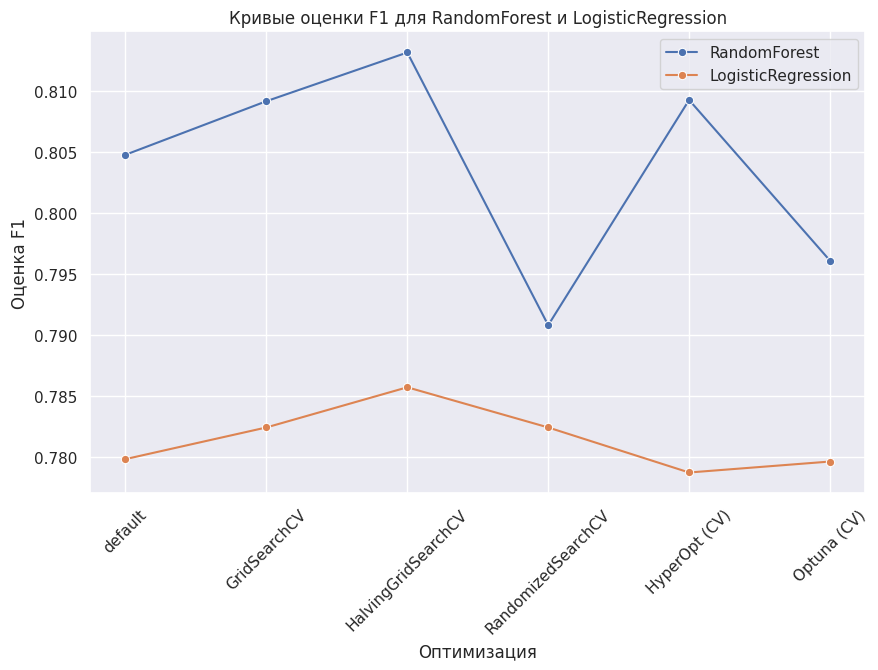

In [66]:
lr_data = score_table.query("name_model == 'Logistic Regression'")
rf_data = score_table.query("name_model == 'RandomForestClassifier'")

# График для RandomForest
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_data, x='optimization', y='test_f1', label='RandomForest', marker='o')

# График для LogisticRegression
sns.lineplot(data=lr_data, x='optimization', y='test_f1', label='LogisticRegression', marker='o')

# Внешний вид графика
plt.title('Кривые оценки F1 для RandomForest и LogisticRegression')
plt.xlabel('Оптимизация')
plt.ylabel('Оценка F1')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()

In [57]:
score_table.loc[0, 'name_model']

'Logistic Regression'

#### Вывод : Классификатор RandomForestClassifier выдает лучшие характеристики по предсказанию по сравнению с логистической регрессией. Разброс лучших параметров возможно либо из-за ограничения MAX_ITER, либо расширить поиск диапазона гиперпараметров